In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
os.chdir("/Users/burke/Documents/research/bpCog/microsim")
#os.chdir("/Users/burke/Documents/microsim")

from microsim.population import NHANESDirectSamplePopulation


import pandas as pd
import numpy as np

import multiprocessing as mp
mp.set_start_method('forkserver')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import pickle

with open('population.json', 'wb') as outputFile:
    pickle.dump(pop, outputFile)

import pickle

with open('population.json', 'rb') as inputFile:
    pop = pickle.load(inputFile)

In [3]:
def buildDF(pop):
    dementia = [person._dementia for i, person in pop._people.iteritems()]
    incidentDementia = [person.has_incident_dementia() for i, person in pop._people.iteritems()]
    dead = [person.is_dead() for i, person in pop._people.iteritems()]


    finalAge = [person._age[-1] for i, person in pop._people.iteritems()]
    startAge = [person._age[0] for i, person in pop._people.iteritems()]
    return pd.DataFrame({'finalAge' : finalAge,'startAge' : startAge, 'dementia' : dementia, 'indicentDementia' : incidentDementia, 'dead' : dead})

In [4]:
pop = NHANESDirectSamplePopulation(n=200000, year=1999)
dfs = []
for i in range(0, 20):
    pop.advance_vectorized(1)
    dfs.append(buildDF(pop))

/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinin

/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine/crThreshold)**exponent * 0.993**x.age
/Users/burke/Documents/research/bpCog/microsim/microsim/gfr_equation.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinin

In [ ]:
from microsim.outcome_model_type import OutcomeModelType

simIncidence = pop.get_raw_incidence_by_age(OutcomeModelType.DEMENTIA)
simIncidenceTruncated = simIncidence.loc[(simIncidence.index >=20) & (simIncidence.index < 90)]
predIncidence = .084*np.exp(0.142 * (simIncidenceTruncated.index-60))/100

##### 

In [ ]:
simIncidence

In [ ]:
plt.plot(range(20,90), simIncidenceTruncated, label="simulation")
plt.plot(range(20,90), predIncidence.values, label="comparison standard")
plt.legend()

In [ ]:
combinedDF = dfs[0][['finalAge', 'startAge']]

for i in range(0, 20):
    combinedDF[f'dementia{i}'] = dfs[i].dementia
    combinedDF[f'incidentDementia{i}'] = dfs[i].indicentDementia
    combinedDF[f'dead{i}'] = dfs[i].dead
    combinedDF[f'incidentNotDead{i}'] =  (dfs[i].indicentDementia) & (~ dfs[i].dead)

In [ ]:
combinedDF.dementia1.value_counts()

In [ ]:
combinedDF.head()

In [ ]:
combinedDF['id'] = combinedDF.index
longDf = pd.wide_to_long(combinedDF, ["incidentDementia", "dead", "dementia", "incidentNotDead"], i="id", j="year")

In [ ]:
longDf['notDead'] = ~ longDf['dead']
longDf['age'] = longDf.startAge + longDf.index.get_level_values('year')


In [ ]:
grouped = longDf.groupby('age')['incidentDementia'].sum()/longDf.groupby('age')['notDead'].sum()
grouped

In [ ]:
groupedTrunc = grouped.loc[(grouped.index > 20) & (grouped.index <= 90)]
plt.plot(groupedTrunc.index, groupedTrunc.values, label="Simulation")

predIncidence2 = .084*np.exp(0.142 * (groupedTrunc.index-60))/100
plt.plot(groupedTrunc.index, predIncidence2.values, label="Calibration Standard")
plt.ylabel("Incidence")
plt.xlabel("Age")
plt.legend()
plt.savefig('dementiaCalibrationFigure.pdf')

In [17]:
actualData = pd.read_stata("/Users/burke/Documents/research/bpCog/nhanes/coxreg_currgcp.dta")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/burke/Documents/research/bpCog/nhanes/coxreg_currgcp.dta'

In [18]:
actualData['roundedAge'] = np.round(actualData.age)
actualGroupedByAge = actualData.groupby('roundedAge')['deminc'].mean()
actualGroupedByAge = actualGroupedByAge[actualGroupedByAge.index < 95]

NameError: name 'actualData' is not defined

In [19]:
plt.plot(actualGroupedByAge.index, actualGroupedByAge.values*100, label='Cohorts')
predIncidence = .084*np.exp(0.142 * (actualGroupedByAge.index-60))
plt.plot(actualGroupedByAge.index, predIncidence, label='Brookmeyer incidence equation')
plt.legend()


NameError: name 'actualGroupedByAge' is not defined

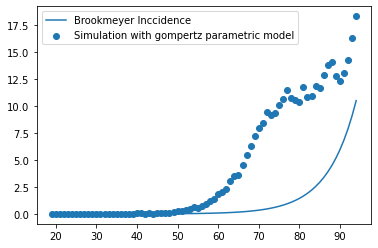

In [12]:
grouped = grouped.loc[grouped.index < 95]
plt.scatter(grouped.index, grouped.values*100, label='Simulation with gompertz parametric model')

predIncidence = .084*np.exp(0.142 * (grouped.index-60))
plt.plot(grouped.index, predIncidence, label='Brookmeyer Inccidence  ')
plt.legend()
plt.savefig('quadraticSurvivalFunctionvVsBrook.pdf')

In [ ]:
from microsim.dementia_model import DementiaModel
from microsim.outcome_model_type import OutcomeModelType

linearPop = NHANESDirectSamplePopulation(n=50000, year=1999)
linearPop._outcome_model_repository._models[OutcomeModelType.DEMENTIA] = DementiaModel(0.00023723, 0)
linearDFs = []
for i in range(0, 20):
    linearPop.advance_multi_process(1)
    linearDFs.append(buildDF(pop))

In [ ]:
combinedDFLinear = linearDFs[0][['finalAge', 'startAge']]

for i in range(0, 20):
    combinedDFLinear[f'dementia{i}'] = linearDFs[i].dementia
    combinedDFLinear[f'incidentDementia{i}'] = linearDFs[i].indicentDementia
    combinedDFLinear[f'dead{i}'] = linearDFs[i].dead
    combinedDFLinear[f'incidentNotDead{i}'] =  (linearDFs[i].indicentDementia) & (~ linearDFs[i].dead)

In [ ]:
combinedDFLinear['id'] = combinedDFLinear.index
longDfLinear = pd.wide_to_long(combinedDFLinear, ["incidentDementia", "dead", "dementia", "incidentNotDead"], i="id", j="year")
longDfLinear['notDead'] = ~ longDfLinear['dead']
longDfLinear['age'] = longDfLinear.startAge + longDfLinear.index.get_level_values('year')
groupedLinear = longDfLinear.groupby('age')['incidentDementia'].sum()/longDfLinear.groupby('age')['notDead'].sum()
groupedLinear = groupedLinear.loc[groupedLinear.index < 95]
plt.scatter(groupedLinear.index, groupedLinear.values*100)

predIncidenceLinear = .084*np.exp(0.142 * (groupedLinear.index-60))
plt.plot(groupedLinear.index, predIncidenceLinear)
plt.savefig('linearSurvivalFunctionCalibrationVsBrookemeyer.pdf')

In [ ]:
from microsim.outcome_model_type import OutcomeModelType

tvcPop = NHANESDirectSamplePopulation(n=50000, year=1999)
tvcPop._outcome_model_repository._models[OutcomeModelType.DEMENTIA] = DementiaModelTVC()
tvcDFs = []
for i in range(0, 20):
    tvcPop.advance_multi_process(1)
    tvcDFs.append(buildDF(tvcPop))

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


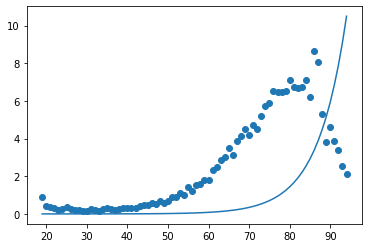

In [4]:
combinedDFTVC = tvcDFs[0][['finalAge', 'startAge']]

for i in range(0, 20):
    combinedDFTVC[f'dementia{i}'] = tvcDFs[i].dementia
    combinedDFTVC[f'incidentDementia{i}'] = tvcDFs[i].indicentDementia
    combinedDFTVC[f'dead{i}'] = tvcDFs[i].dead
    combinedDFTVC[f'incidentNotDead{i}'] =  (tvcDFs[i].indicentDementia) & (~ tvcDFs[i].dead)

combinedDFTVC['id'] = combinedDFTVC.index
longDfTVC = pd.wide_to_long(combinedDFTVC, ["incidentDementia", "dead", "dementia", "incidentNotDead"], i="id", j="year")
longDfTVC['notDead'] = ~ longDfTVC['dead']
longDfTVC['age'] = longDfTVC.startAge + longDfTVC.index.get_level_values('year')
groupedTVC = longDfTVC.groupby('age')['incidentDementia'].sum()/longDfTVC.groupby('age')['notDead'].sum()
groupedTVC = groupedTVC.loc[groupedTVC.index < 95]
plt.scatter(groupedTVC.index, groupedTVC.values*100)

predIncidenceTVC = .084*np.exp(0.142 * (groupedTVC.index-60))
plt.plot(groupedTVC.index, predIncidenceTVC)
plt.savefig('linearSurvivalFunctionCalibrationVsBrookemeyerTVC.pdf')

In [ ]:
### left off here — checking what it looks like if i reverse the quadratic terms...maybe not so bad?

In [13]:
### option 1...baseline quadratic
### optoin 2...baseline linear
### option 3...age as tvc + baseline = ?

In [ ]:
oneYearRisks = [DementiaModel().get_risk_for_person(person, 1) for _, person in oneYearPop._people.iteritems()]
oneYearCumulativeHazards = [DementiaModel().get_cumulative_hazard(person) for _, person in oneYearPop._people.iteritems()]
oneYearLinearPredictors = [DementiaModel().linear_predictor(person) for _, person in oneYearPop._people.iteritems()]

In [32]:
pd.Series(oneYearRisks).describe()

count    100000.000000
mean          0.004941
std           0.018683
min           0.000004
25%           0.000047
50%           0.000191
75%           0.001410
max           0.405354
dtype: float64

In [33]:
pd.Series(oneYearCumulativeHazards).describe()

count    1.000000e+05
mean     6.978571e-05
std      8.164083e-17
min      6.978571e-05
25%      6.978571e-05
50%      6.978571e-05
75%      6.978571e-05
max      6.978571e-05
dtype: float64

In [34]:
pd.Series(oneYearLinearPredictors).describe()

count    100000.000000
mean          1.439264
std           2.338159
min          -2.764880
25%          -0.401755
50%           1.008101
75%           3.005945
max           8.667087
dtype: float64

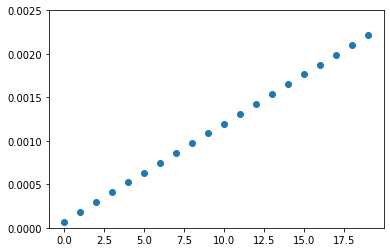

In [50]:
t = np.arange(0, 20, 1) 
haz = DementiaModel().get_cumulative_hazard_for_interval(t, t+1)
plt.ylim(0, 0.0025)
plt.scatter(t, haz)

In [41]:
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [42]:
t+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [43]:
haz

array([6.97857080e-05, 1.82682876e-04, 2.95580044e-04, 4.08477213e-04,
       5.21374381e-04, 6.34271549e-04, 7.47168717e-04, 8.60065885e-04,
       9.72963054e-04, 1.08586022e-03, 1.19875739e-03, 1.31165456e-03,
       1.42455173e-03, 1.53744889e-03, 1.65034606e-03, 1.76324323e-03,
       1.87614040e-03, 1.98903757e-03, 2.10193474e-03, 2.21483190e-03])

In [44]:
1.33371239e-05+5.64485841e-05

6.9785708e-05

In [54]:
(1.33371239e-05*3+5.64485841e-05*9) - (1.33371239e-05*2+5.64485841e-05*4)

0.00029558004440000005